In [14]:
import xgboost as xgb
import pandas as pd
from math import radians, cos
from datetime import datetime, date, timedelta
import pandas as pd
from initial_data_pull_test import data_pull
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

nj_transit_locations = {
    'brick_church': [40.76581846318419, -74.21915255150205],
    'chatham': [40.7401922968325, -74.38473871480802],
    'convent_station': [40.778934521406896, -74.44347183325733],
    'denville': [40.88348292558847, -74.48184630211975],
    'dover': [40.887548571222204, -74.55589964058176],
    'east_orange': [40.761460414532, -74.21100276083385],
    'hackettstown': [40.85215082333791, -74.83467888781628],
    'highland_avenue': [40.766972457228775, -74.24355123014908],
    'hoboken': [40.70898046045857, -74.0246430608362], #
    'lake_hopatcong': [40.904119814030835, -74.66555031993157],
    'madison': [40.757211574757704, -74.41541459013588],
    'maplewood': [40.7311582228973, -74.27530904549292],
    'millburn': [40.72583754037974, -74.303745189671],
    'morris_plains': [40.828733316576745, -74.47839671850174],
    'morristown': [40.79756715723661, -74.47460155149217],
    'mountain_station': [40.76109170550611, -74.25347657839343],
    'mount_arlington': [40.89752890181971, -74.63289981056195],
    'mount_olive': [40.90760134999547, -74.73072365897825],
    'mount_tabor': [40.8759878570467, -74.48183704548632],
    'netcong': [40.898021200833895, -74.70758666495435],
    'newark_broad': [40.74757642090106, -74.17199820501222],
    'orange': [40.77209415825383, -74.23309422970475],
    'secaucus_junction': [40.76142100515953, -74.07575294623813],
    'short_hills': [40.725313887730955, -74.3238799338488],
    'south_orange': [40.74603125221472, -74.26046288967005],
    'summit': [40.71681594165216, -74.35768690713812]
}



def find_station(lat_long):
    apt_lat, apt_long = lat_long.split('_')
    apt_lat, apt_long = float(apt_lat), float(apt_long)
    
    for train_station, locations in nj_transit_locations.items():
        middle_lat = locations[0]
        middle_long = locations[1]
        
        small_lat, large_lat = middle_lat - 0.75 / 68.97, middle_lat + 0.75 / 68.97
        small_long, large_long = middle_long - 0.75 / 55.77, middle_long + 0.75 / 55.77
        
        if apt_lat >= small_lat and apt_lat <= large_lat:
            if apt_long >= small_long and apt_long <= large_long:
                return train_station
            
    return 'not close'
    
def clean_dates(df):
    df.listedDate = pd.to_datetime(df.listedDate).dt.date
    df = df.loc[df.listedDate.max() - timedelta(days=14)]
    return df

In [48]:
# !pipenv install seaborn

Installing seaborn...
✔ Installation Succeeded
Installing dependencies from Pipfile.lock (7ad131)...
All dependencies are now up-to-date!
Upgrading seaborn in  dependencies.
Building requirements...
Resolving dependencies....
✔ Success! Locking packages...
⠋ Locking packages...
Building requirements...
Resolving dependencies....
✔ Success! Locking packages...
⠇ Locking packages...
Building requirements...
Resolving dependencies....
✔ Success! Locking packages...
⠼ Locking packages...
Installing dependencies from Pipfile.lock (1ddad5)...
All dependencies are now up-to-date!
Installing dependencies from Pipfile.lock (1ddad5)...


In [49]:
import seaborn as sns

In [15]:
df = pd.read_csv('seventh_load.csv')

In [16]:
df.zipCode = df.zipCode.astype(str)

In [17]:
df.columns

Index(['id', 'formattedAddress', 'addressLine1', 'addressLine2', 'city',
       'state', 'zipCode', 'county', 'latitude', 'longitude', 'propertyType',
       'bedrooms', 'bathrooms', 'status', 'price', 'listingType', 'listedDate',
       'removedDate', 'createdDate', 'lastSeenDate', 'daysOnMarket',
       'squareFootage', 'yearBuilt', 'lotSize', 'mlsName', 'mlsNumber',
       'listingAgent', 'listingOffice', 'hoa'],
      dtype='object')

In [23]:
df[['yearBuilt']].isna().sum()

yearBuilt    135
dtype: int64

In [32]:
df.shape

(652, 29)

In [33]:
feats = [
    # 'city',
    'latitude', 'longitude',
    'propertyType','bedrooms', 'bathrooms', 'yearBuilt', 'lotSize'
]

In [34]:
X_train, X_test, y_train, y_test = train_test_split(
    df[feats], df.price, test_size=0.2, random_state=42
)


In [35]:
# le_zip = LabelEncoder()
le_pt = LabelEncoder()

In [36]:
# X_train['city'] = le_zip.fit_transform(X_train['city'])
X_train['propertyType'] = le_zip.fit_transform(X_train['propertyType'])

# X_test['city'] = le_zip.transform(X_test['city'])
X_test['propertyType'] = le_zip.transform(X_test['propertyType'])

In [39]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_test, label=y_test)

In [40]:
best_params = {
    'learning_rate': 0.09585355369315604,
    'max_depth': 30,
    'min_child_weight': 1.060597050922164,
    'objective': 'reg:linear',
    'reg_alpha': 0.018060244040060163,
    'reg_lambda': 0.011658731377413597,
    'seed': 42
}

In [41]:
booster = xgb.train(
    params=best_params,
    dtrain=train,
    num_boost_round=1000,
    evals=[(valid, 'validation')],
    early_stopping_rounds=50
)

[0]	validation-rmse:1248.41253
[1]	validation-rmse:1134.12752
[2]	validation-rmse:1036.41365
[3]	validation-rmse:954.10726
[4]	validation-rmse:884.65279
[5]	validation-rmse:827.82920
[6]	validation-rmse:782.75740
[7]	validation-rmse:749.62380
[8]	validation-rmse:721.40411
[9]	validation-rmse:707.67828
[10]	validation-rmse:692.57948
[11]	validation-rmse:684.93018
[12]	validation-rmse:678.51597
[13]	validation-rmse:676.11459
[14]	validation-rmse:669.15214
[15]	validation-rmse:665.93996
[16]	validation-rmse:670.06196
[17]	validation-rmse:668.20193
[18]	validation-rmse:671.67494
[19]	validation-rmse:668.78028
[20]	validation-rmse:672.96441
[21]	validation-rmse:672.00287


/home/codespace/.local/share/virtualenvs/apartment_rental_north_nj-7H8uMaQy/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [01:31:07] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[22]	validation-rmse:676.68786
[23]	validation-rmse:678.54452
[24]	validation-rmse:682.99799
[25]	validation-rmse:684.02798
[26]	validation-rmse:685.08241
[27]	validation-rmse:684.42780
[28]	validation-rmse:684.46549
[29]	validation-rmse:684.70922
[30]	validation-rmse:685.69692
[31]	validation-rmse:688.45600
[32]	validation-rmse:688.84156
[33]	validation-rmse:690.13846
[34]	validation-rmse:690.20974
[35]	validation-rmse:691.90109
[36]	validation-rmse:692.61702
[37]	validation-rmse:692.18256
[38]	validation-rmse:691.95525
[39]	validation-rmse:693.33918
[40]	validation-rmse:693.80736
[41]	validation-rmse:694.91237
[42]	validation-rmse:695.31508
[43]	validation-rmse:694.84434
[44]	validation-rmse:694.81707
[45]	validation-rmse:695.67761
[46]	validation-rmse:695.85268
[47]	validation-rmse:696.95239
[48]	validation-rmse:696.53030
[49]	validation-rmse:696.08130
[50]	validation-rmse:695.76314
[51]	validation-rmse:695.54370
[52]	validation-rmse:696.31554
[53]	validation-rmse:696.36671
[54]	val

In [42]:
y_pred = booster.predict(valid)

In [43]:
y_pred

array([ 2180.8723,  3580.7273,  4783.8745,  4655.8276,  2105.2305,
        2008.3956,  3790.4597,  2002.033 ,  3815.0718,  2226.803 ,
        4248.743 ,  3592.6772,  5221.7627,  2408.105 ,  3183.4658,
        3876.8462,  2885.412 ,  5477.345 ,  2994.411 ,  1973.9846,
        3592.3423,  1539.9742,  2565.5537,  3425.174 ,  1877.0376,
        4693.527 ,  2964.364 ,  3229.7085,  2276.1624,  3109.7795,
        2502.3826,  1688.5962,  2231.1409,  2349.4285,  3845.8198,
        4103.994 ,  4564.0103,  3001.4082,  3947.6528,  8807.249 ,
       13131.052 ,  2597.6729,  2713.7805,  4382.9614,  5152.6772,
        2806.8762,  3789.5767,  4339.8887,  2143.1768,  2274.2158,
        2988.655 ,  1413.9291,  2161.3296,  4290.486 ,  3758.3833,
        3104.1362,  4889.2075,  2603.7537,  2207.5522,  2470.6555,
        2133.6736,  2819.3477,  2922.7864,  3856.0178,  4704.5503,
        3778.4006,  2452.2014,  5444.671 ,  4433.964 ,  2681.1196,
        1703.3654,  2568.0576,  2104.5166,  2180.6018,  1953.6

In [51]:
from sklearn.metrics import root_mean_squared_error
import matplotlib.pyplot as plt

In [52]:
root_mean_squared_error(y_pred=y_pred, y_true=y_test)

698.7727661132812

In [53]:

root_mean_squared_error(y_pred=booster.predict(train), y_true=y_train)

80.08328247070312

/tmp/ipykernel_50383/644845123.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_50383/644845123.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


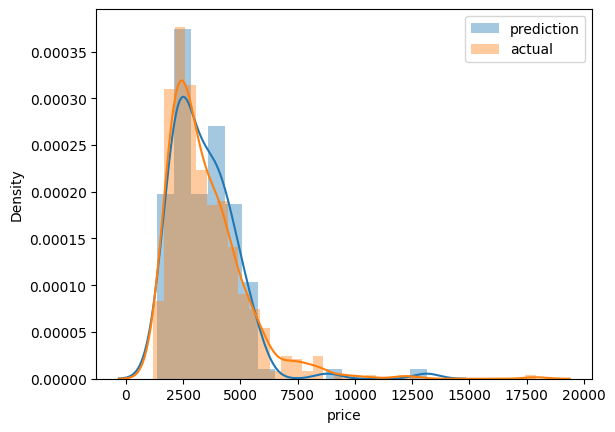

In [54]:
df_test = X_test
df_test['price'] = y_test
df_test['pred'] = y_pred
df_test['diff'] = y_test - y_pred


sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

/tmp/ipykernel_50383/3755871570.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_test['diff'])


<Axes: xlabel='diff', ylabel='Density'>

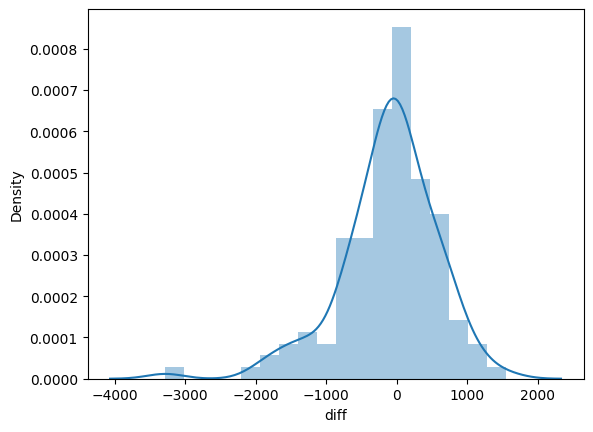

In [55]:
sns.distplot(df_test['diff'])